# ML Models on Simulation Data

In [1]:
import os
os.getcwd()

'/home/nfs/dengy/dl-survival-miRNA/examples'

In [1]:
# use pip to install pandas, matplotlib if needed
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

from sklearn import set_config
from sklearn.model_selection import train_test_split
set_config(display="text")  # displays text representation of estimators

os.chdir("../")
from scr.utils import *
from scr.runSurvModels import *


In [2]:
date='101724'

In [3]:
# prepare data
folder = 'nonlinear'
keywords=['nl-gauss', date,'RW']
DATANAME = 'nl-gauss-RW'
train_df, test_df = load_simulate_survival_data(folder=folder, keywords=keywords)

# prepare data
X_train, y_train = dataframe_to_scikitsurv_ds(train_df)
X_test, y_test = dataframe_to_scikitsurv_ds(test_df)

Train event rate: 0.753875
Test event rate:  0.758


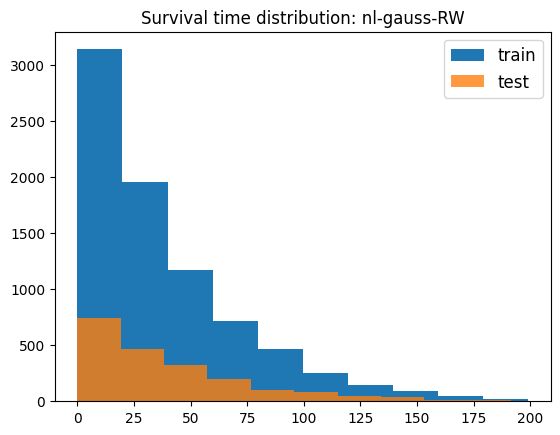

In [4]:
print(f"Train event rate: {train_df.status.value_counts()[1]/train_df.shape[0]}")
print(f"Test event rate:  {test_df.status.value_counts()[1] /test_df.shape[0]}")

plt.hist(train_df['time'], label='train')
plt.hist(test_df['time'], label='test', alpha=0.8)
plt.title('Survival time distribution: %s' % DATANAME)
plt.legend(fontsize=12)
plt.show()
# plt.savefig(f"event_rate_{keyword}.png")

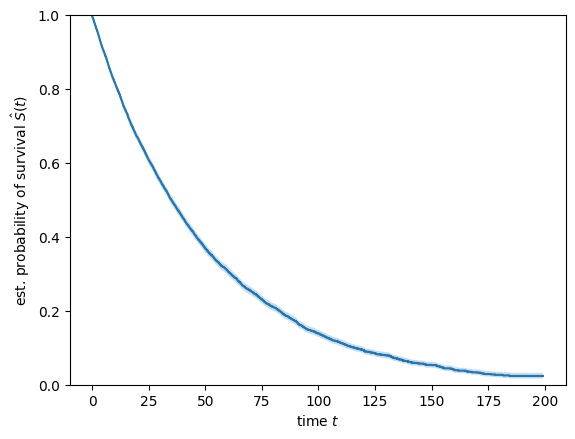

In [5]:
from sksurv.nonparametric import kaplan_meier_estimator

time, survival_prob, conf_int = kaplan_meier_estimator(
    train_df["status"]==1, train_df["time"], conf_type="log-log"
)
plt.step(time, survival_prob, where="post")
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.ylim(0, 1)
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.show()

# Tree Methods

In [13]:
class EarlyStoppingMonitor:
    def __init__(self, window_size, max_iter_without_improvement):
        self.window_size = window_size
        self.max_iter_without_improvement = max_iter_without_improvement
        self._best_step = -1

    def __call__(self, iteration, estimator, args):
        if iteration < self.window_size:
            return False

        # compute average improvement in last self.window_size iterations.
        # oob_improvement_ is the different in negative log partial likelihood
        # between the previous and current iteration.
        start = iteration - self.window_size + 1
        end = iteration + 1
        improvement = np.mean(estimator.oob_improvement_[start:end])

        if improvement > 1e-6:
            self._best_step = iteration
            return False  # continue fitting

        # stop fitting if there was no improvement
        # in last max_iter_without_improvement iterations
        diff = iteration - self._best_step
        return diff >= self.max_iter_without_improvement

# rsf_early_stopping = RandomSurvivalForest(
#     n_estimators=1000, min_samples_split=10, min_samples_leaf=15, n_jobs=-1, random_state=42
# )
monitor = EarlyStoppingMonitor(10, 5)
# rsf_early_stopping.fit(X_train, y_train, monitor=monitor)
# print("Fitted base learners:", rsf_early_stopping.n_estimators_)
# cindex = rsf_early_stopping.score(X_test, y_test)
# print("Performance on test set", round(cindex, 3))

## Random Survival Forest

### Hyperparameter search

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             error_score=0.5,
             estimator=RandomSurvivalForest(max_depth=3, n_estimators=500,
                                            n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'min_samples_leaf': [5, 15, 25],
                         'min_samples_split': [3, 10, 20]})

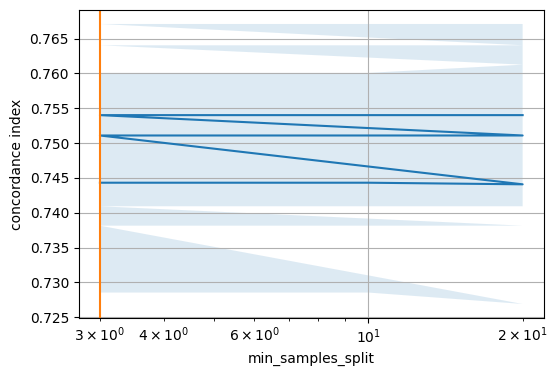

In [4]:
manual_hyperparameters = {
    # 'n_estimators': [100, 500,800],
    # 'max_depth': [3, 5, 7],
    'min_samples_split': [3,10,20],
    'min_samples_leaf': [5,15,25]
}
# parameters for fitting RSF models
kwargs = {
    'n_estimators':500,
    'max_depth': 3,
    # 'min_samples_split':10,
    # 'min_samples_leaf':15,
    'n_jobs':0, 
    'random_state':42
}
rsf = RandomSurvivalForestModel(X_train[:1000], y_train[:1000], X_test, y_test,
                                hyperparameters=manual_hyperparameters)
rsf.build_model(**kwargs)
search = rsf.tune_hyperparameters(n_split=5, plotting_param='min_samples_split')
search

In [6]:
rsf.model

RandomSurvivalForest(max_depth=3, min_samples_leaf=25, min_samples_split=3,
                     n_estimators=500, n_jobs=-1, random_state=42)

### Training

In [7]:
# parameters for fitting RSF models
# output_dir = os.path.join('models',keyword, 'rsf')
subset = [
  50,200,500,1000,2000,#5000,#8000
]
kwargs = {'n_estimators':500, 
          'min_samples_split':10,
        'min_samples_leaf':15,
        'n_jobs':1, 
        'random_state':42}
rsf = RandomSurvivalForestModel(X_train, y_train, X_test, y_test, dataName=DATANAME)
rsf.build_model(**kwargs)
rsf_results, rsf_dict = rsf.train(subset=subset)
# rsf.write(rsf_dict)

N=50 Training time (0.71s): Train C-Index: 0.807 | Test C-index: 0.505
N=200 Training time (5.63s): Train C-Index: 0.829 | Test C-index: 0.498
N=500 Training time (52.0s): Train C-Index: 0.857 | Test C-index: 0.497
N=1000 Training time (340.53s): Train C-Index: 0.869 | Test C-index: 0.505
N=2000 Training time (1264.0s): Train C-Index: 0.869 | Test C-index: 0.501


## Gradient Boosting

In [16]:
from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder

### Hyperparameter Search

In [10]:
est_early_stopping = GradientBoostingSurvivalAnalysis(
    n_estimators=1000, learning_rate=0.1, subsample=0.5, max_depth=1, random_state=0
)

monitor = EarlyStoppingMonitor(10, 5)

est_early_stopping.fit(X_train, y_train, monitor=monitor)

print("Fitted base learners:", est_early_stopping.n_estimators_)

cindex = est_early_stopping.score(X_test, y_test)
print("Performance on test set", round(cindex, 3))

NameError: name 'EarlyStoppingMonitor' is not defined

In [16]:
gb_kwargs = {
    'n_estimators':500, 
    # 'n_jobs':-1, 
    'random_state':42
}
gb_hyperparameters = {
    'learning_rate': [0.1, 0.9],
    'max_depth': [1, 5, 10]
}

gb =  GradientBoostingSurvivalModel(X_train[:500], y_train[:500], X_test, y_test,
                                    hyperparameters=gb_hyperparameters)
gb.build_model(**gb_kwargs)
gb_cv = gb.tune_hyperparameters(n_split=5)
pd.DataFrame(gb_cv.cv_results_)

/home/nfs/dengy/mind-crc-env/lib/python3.10/site-packages/sksurv/linear_model/coxph.py:83: RuntimeWarning: overflow encountered in exp
  self.baseline_survival_ = StepFunction(uniq_times, np.exp(-y))
/home/nfs/dengy/mind-crc-env/lib/python3.10/site-packages/sksurv/linear_model/coxph.py:83: RuntimeWarning: overflow encountered in exp
  self.baseline_survival_ = StepFunction(uniq_times, np.exp(-y))
/home/nfs/dengy/mind-crc-env/lib/python3.10/site-packages/sksurv/linear_model/coxph.py:83: RuntimeWarning: overflow encountered in exp
  self.baseline_survival_ = StepFunction(uniq_times, np.exp(-y))
/home/nfs/dengy/mind-crc-env/lib/python3.10/site-packages/sksurv/linear_model/coxph.py:83: RuntimeWarning: overflow encountered in exp
  self.baseline_survival_ = StepFunction(uniq_times, np.exp(-y))
/home/nfs/dengy/mind-crc-env/lib/python3.10/site-packages/sksurv/linear_model/coxph.py:83: RuntimeWarning: overflow encountered in exp
  self.baseline_survival_ = StepFunction(uniq_times, np.exp(-y))


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,78.987563,0.940394,0.018028,0.028702,0.1,1,"{'learning_rate': 0.1, 'max_depth': 1}",0.830909,0.816364,0.804242,0.841818,0.822626,0.823192,0.012748,1
1,246.343846,4.950607,0.005623,0.000440,0.1,5,"{'learning_rate': 0.1, 'max_depth': 5}",0.810505,0.809899,0.789697,0.796768,0.790707,0.799515,0.009057,4
2,309.232191,4.486070,0.009736,0.000189,0.1,10,"{'learning_rate': 0.1, 'max_depth': 10}",0.748081,0.759192,0.746263,0.718384,0.754747,0.745333,0.014250,6
3,78.518984,1.109372,0.003462,0.000050,0.9,1,"{'learning_rate': 0.9, 'max_depth': 1}",0.811111,0.804040,0.812121,0.808485,0.807273,0.808606,0.002873,3
4,244.037484,6.315745,0.005808,0.000743,0.9,5,"{'learning_rate': 0.9, 'max_depth': 5}",0.827879,0.820202,0.809091,0.812121,0.806667,0.815192,0.007815,2
5,336.418411,25.017336,0.010486,0.000395,0.9,10,"{'learning_rate': 0.9, 'max_depth': 10}",0.767273,0.782828,0.763434,0.729495,0.754343,0.759475,0.017590,5


### Training

In [17]:
# parameters for fitting GB models
subset=[
        50,200,500,1000,2000,5000#,8000
]
kwargs = {'n_estimators':500, 
        'learning_rate':0.1,
        'max_depth':1,
        # 'n_jobs':-1, 
        'random_state':42}
gb = GradientBoostingSurvivalModel(X_train, y_train, X_test, y_test, dataName=DATANAME)
gb.build_model(**kwargs)
gb_results, gb_dict = gb.train(subset=subset)
gb.write(gb_dict)

N=50 Training time (2.15s): Train C-Index: 0.998 | Test C-index: 0.693
N=200 Training time (9.68s): Train C-Index: 0.926 | Test C-index: 0.755
N=500 Training time (26.79s): Train C-Index: 0.871 | Test C-index: 0.771
N=1000 Training time (60.16s): Train C-Index: 0.838 | Test C-index: 0.773
N=2000 Training time (142.34s): Train C-Index: 0.813 | Test C-index: 0.781
N=5000 Training time (499.89s): Train C-Index: 0.797 | Test C-index: 0.788


# Baseline: CoxPH model

In [5]:
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sklearn.model_selection import GridSearchCV, KFold

### Hyperparameter Search

/tmp/ipykernel_377934/3934129116.py:1: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=1000).
  coxnet = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.001, max_iter=1000).fit(X_train, y_train)


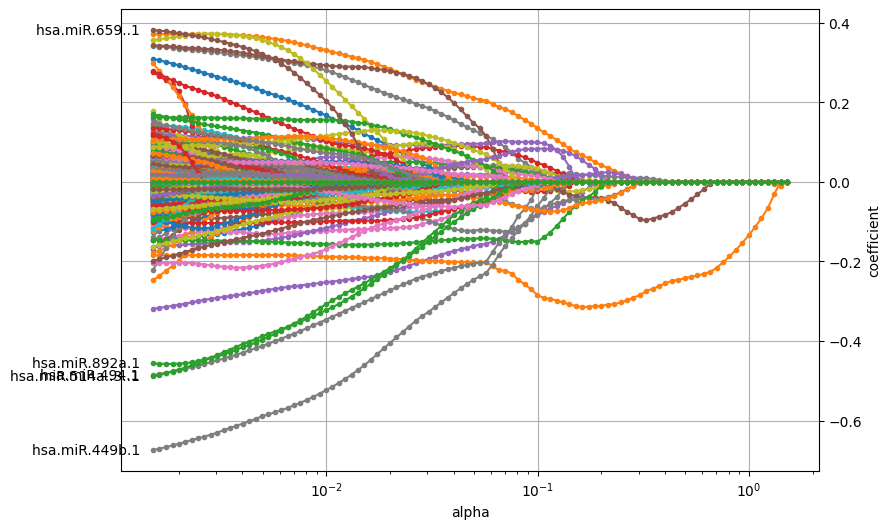

In [70]:
coxnet = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.001, max_iter=1000).fit(X_train, y_train)

coefficients = pd.DataFrame(coxnet.coef_, index=train_df.columns[:-2], columns=np.round(coxnet.alphas_, 5))
plot_coefficients(coefficients, n_highlight=5)

In [12]:
alphas =  [0.001,0.01,0.1] #coxnet.alphas_

coxnet_hyperparameters={
    "alphas": [[a] for a in alphas],
    'l1_ratio': [0.1, 0.9]
}
coxnet = CoxPHElasticNetModel(X_train, y_train, X_test, y_test,
                            hyperparameters=coxnet_hyperparameters)
coxnet = build_model({''})

cv_results = pd.DataFrame(coxnet_cv.cv_results_)

In [13]:
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alphas,param_l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,46.204700,1.347625,0.055914,0.001843,[0.001],0.1,"{'alphas': [0.001], 'l1_ratio': 0.1}",0.911458,0.905810,0.908276,0.910700,0.908393,0.908927,0.001999,4
1,42.287379,2.126294,0.056750,0.007874,[0.001],0.9,"{'alphas': [0.001], 'l1_ratio': 0.9}",0.915196,0.909837,0.912978,0.914337,0.911887,0.912847,0.001883,2
2,34.823239,2.155184,0.093512,0.008081,[0.01],0.1,"{'alphas': [0.01], 'l1_ratio': 0.1}",0.913515,0.907758,0.911669,0.914191,0.911716,0.911770,0.002237,3
3,29.688668,1.168285,0.124735,0.025512,[0.01],0.9,"{'alphas': [0.01], 'l1_ratio': 0.9}",0.918818,0.913556,0.917085,0.919981,0.916771,0.917242,0.002183,1
4,16.543225,2.392059,0.178689,0.029070,[0.1],0.1,"{'alphas': [0.1], 'l1_ratio': 0.1}",0.901618,0.895208,0.900865,0.904381,0.900726,0.900560,0.002983,5
5,1.755442,0.192350,0.242111,0.042911,[0.1],0.9,"{'alphas': [0.1], 'l1_ratio': 0.9}",0.866313,0.859564,0.870020,0.872047,0.861307,0.865850,0.004820,6


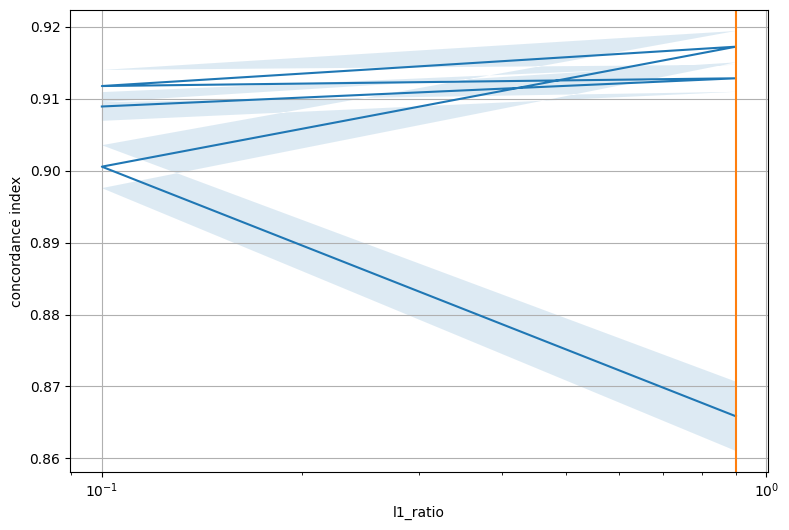

In [37]:
param = 'l1_ratio'
try:
    params = cv_results[f'param_{param}'].map(lambda x: x[0])
except TypeError:
    params = cv_results[f'param_{param}']
mean = cv_results.mean_test_score
std = cv_results.std_test_score


fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(params, mean)
ax.fill_between(params, mean - std, mean + std, alpha=0.15)
ax.set_xscale("log")
ax.set_xlabel(param)
ax.set_ylabel("concordance index")
ax.axvline(coxnet_cv.best_params_[param][0] 
            if isinstance(coxnet_cv.best_params_[param], list)
            else coxnet_cv.best_params_[param], 
        c="C1")
ax.grid(True)

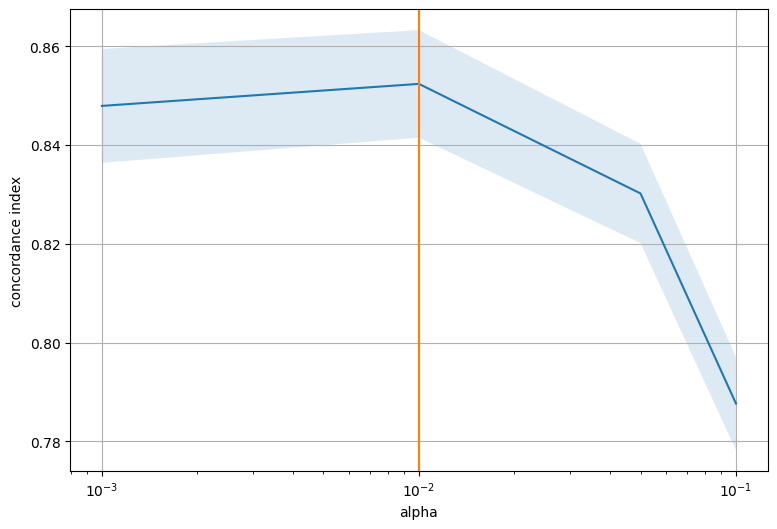

In [50]:
alphas = cv_results.param_alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean - std, mean + std, alpha=0.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.axvline(coxnet_cv.best_params_["alphas"][0], c="C1")
# ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True)

In [36]:
coxnet_cv.best_estimator_

CoxnetSurvivalAnalysis(alphas=[0.01], l1_ratio=0.9)

### Training model with best parameter

In [6]:
# parameters for fitting GB models
subset=[
        50,200,500,1000,2000,5000,8000
]
kwargs = {'l1_ratio':0.9, 
        'alphas':[1e-2],
        'max_iter':20000
        }
coxnet = CoxPHElasticNetModel(X_train, y_train, X_test, y_test, dataName=DATANAME)
coxnet.build_model(**kwargs)
coxnet_results, coxnet_dict = coxnet.train(subset=subset)
coxnet_results
# coxnet.write(coxnet_dict)

N=50 Training time (0.29s): Train C-Index: 1.0 | Test C-index: 0.503
N=200 Training time (0.23s): Train C-Index: 0.889 | Test C-index: 0.484
N=500 Training time (0.09s): Train C-Index: 0.711 | Test C-index: 0.501
N=1000 Training time (0.08s): Train C-Index: 0.647 | Test C-index: 0.503
N=2000 Training time (0.06s): Train C-Index: 0.58 | Test C-index: 0.499
N=5000 Training time (0.08s): Train C-Index: 0.545 | Test C-index: 0.485
N=8000 Training time (0.14s): Train C-Index: 0.523 | Test C-index: 0.481


,n train,train time,train score,test score
0,50,0.29,1.000000,0.502712
1,200,0.23,0.889161,0.484068
2,500,0.09,0.710796,0.501011
3,1000,0.08,0.646585,0.502970
4,2000,0.06,0.580195,0.498610
5,5000,0.08,0.545079,0.485445
6,8000,0.14,0.522839,0.481204


In [24]:
coxnet_results.to_csv(os.path.join('models', DATANAME, 'coxnet','model.results.1004.txt'))

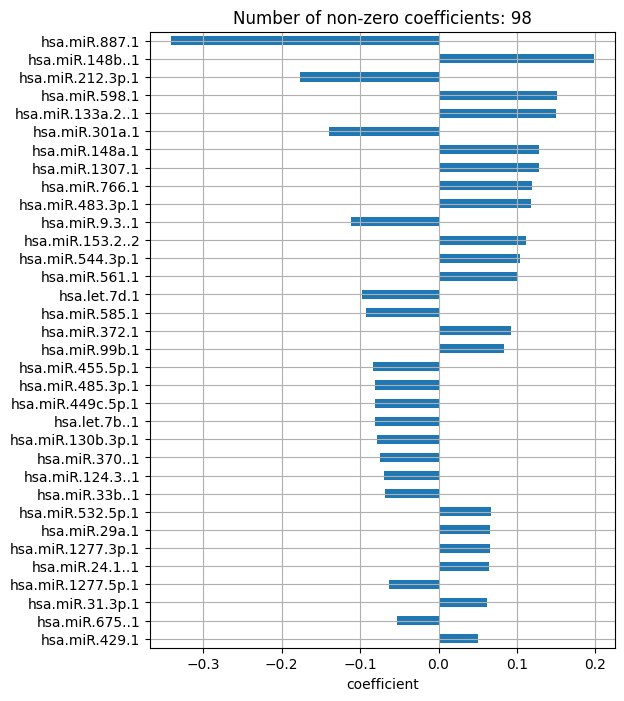

In [25]:
coefficients =  pd.DataFrame({'coefficient': [v[0] for v in coxnet_dict['8000'].coef_]}, 
                            index=train_df.columns[:-3])
# coefficients[coefficients!=0]

non_zero = np.sum(coefficients.iloc[:, 0] != 0)

non_zero_coefs = coefficients[abs(coefficients["coefficient"]) > 5e-2]
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

fig, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)
ax.set_title(f"Number of non-zero coefficients: {non_zero}")
fig.savefig(
    os.path.join("models",DATANAME, 'coxnet','top-coefficients.jpg')
)